<a href="https://colab.research.google.com/github/Shi-raishi/Research/blob/main/pattern2_fnutr1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ②f_nutr1シートのE_CR～E_SSまでの１７食品群別エネルギー<br>
## 分析前にnutrシートにある変数EER, EN から求まるエネルギー補正係数(EER/EN) をかける<br>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Google Colabにlingamのライブラリをインストールする
!pip install lingam

In [ ]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot
from lingam.utils import print_causal_directions, print_dagc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

['1.26.2', '1.5.3', '0.20.1', '1.8.2']


##  関数を定義

In [ ]:
# 前処理用（結合、重複削除、NA削除）
def preprocess(df1, df2):
  # df1, df2の重複を確認
  print(f"ID1に重複のある行数\tdf1:{df1['ID1'].duplicated(keep=False).sum()}\tdf2:{df2['ID1'].duplicated(keep=False).sum()}")

  # df2からID1の重複を除去
  df2_cleaned = df2.drop_duplicates(subset='ID1', keep=False)

  # 左結合
  merged_data = pd.merge(df1, df2_cleaned, on='ID1', how='left')

  # 結合後のデータフレームのID1の重複を削除
  merged_data = merged_data.drop_duplicates(subset='ID1',keep=False)# 重複の確認
  print(f"結合後のデータ数:{len(merged_data)}")

  ## エネルギー補正係数とBMIを作成
  # merged_dataのコピーを作成（SettingWithCopyWarningというエラーが出るため）
  merged_data_copy = merged_data.copy()

  # 新しい列を追加(ECF:Energy correction facto(エネルギー補正係数))
  merged_data_copy['BMI'] = merged_data_copy['BW'] / ((merged_data_copy['BH'] / 100) ** 2)
  merged_data_copy['ECF'] = merged_data_copy['EER'] / merged_data_copy['EN']

  # 変数を選択
  selected_columns = merged_data_copy.loc[:, 'E_CR':'E_SS'].copy()
  selected_columns['BMI'] = merged_data_copy['BMI']
  selected_columns['ECF'] = merged_data_copy['ECF']
  selected_columns['AGE'] = merged_data_copy['AGE']
  selected_columns['SEX'] = merged_data_copy['SEX']

  # NA処理
  print(f"NAを含むデータ数:{selected_columns[selected_columns.isna().any(axis=1)].shape[0]}")
  selected_columns_cleaned = selected_columns.dropna()
  selected_columns_cleaned.describe()
  display(selected_columns_cleaned.describe())

  print(f"処理後のデータ数:{len(selected_columns_cleaned)}")

  return selected_columns_cleaned

In [ ]:
# 変数同士の相関を確認
def corrMatrix(df):
  # 相関行列の作成
  corr_matrix = df.corr()

  # 高い相関を持つ変数ペアの抽出
  threshold = 0.5  # 閾値を設定
  high_corr_var = [(column, index, corr_matrix[column][index]) for column in corr_matrix.columns for index in corr_matrix.columns if (corr_matrix[column][index] > threshold) & (column != index)]
  for var_pair in high_corr_var:
      print(var_pair)

In [ ]:
# 特定の変数と他の変数との相関を確認
def targetCorrMatrix(df):
  df = 'VEG3'
  correlations = df.corrwith(df[df])
  correlations.sort_values(ascending=False)

In [ ]:
# ヒートマップで相関関係の可視化
def heatMap(df):
  plt.figure(figsize=(15, 15))
  sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
  plt.show()

In [ ]:
# 個々の変数の分布を確認
def distribution(df):
  for column in df.columns:
      plt.figure()
      sns.histplot(df[column], kde=True)
      plt.title(column)
      plt.show()

In [ ]:
# 変数の0データを確認
def countZeroData(df):
  # 各変数における0の数をカウントし、少ない順にソート
  zero_counts_sorted = (df == 0).sum().sort_values()
  # 各変数における0データ数の表示
  print(zero_counts_sorted)

In [ ]:
# 0データの数をグラフで確認
def countAvairableVariable(df):
  # 0が含まれる数をカウント
  zero_counts = (df == 0).sum().sort_values()

  # グラフのサイズを設定
  plt.figure(figsize=(12, 9))

  # 棒グラフの作成
  sns.barplot(x=len(df)-zero_counts.values, y=zero_counts.index)

  # グラフのタイトルとラベルを設定
  plt.title('Number of non-zero data in each variable')
  plt.xlabel('number of non-zero data')
  plt.ylabel('variable name')

  # グラフの表示
  plt.show()

In [ ]:
def boxplot(df):
  # dfのすべての列に対して箱ひげ図を描画
  plt.figure(figsize=(10, 6))
  sns.boxplot(data=df)
  plt.title("Boxplot of df")
  plt.show()

In [ ]:
# 与えられたデータフレームの変数を見る
def checksVariables(df):
  # non-zeroのデータ数をグラフで確認
  countAvairableVariable(df)
  # 相関行列を確認
  corrMatrix(df)
  # ヒートマップ確認
  heatMap(df)
  # # 各変数の分布を確認
  # distribution(df)
  # 箱ひげ図を描画
  # boxplot(df)

In [ ]:
# 解析に使用するデータフレームを返す
def select_variables(df,columns):
    # 解析に使用する変数のデータフレームを作成
    df = df[columns]

    # 基本統計量の確認
    # print(f"データ数:{len(df)}")
    # display(df.describe())

    # # 各列について、上:0.05%,下:0.05%のデータを外れ値として除去
    # for column in df.columns:
    #     lower_limit = df[column].quantile(0.005)
    #     upper_limit = df[column].quantile(0.995)
    #     df = df[(df[column] > lower_limit) & (df[column] < upper_limit)]

    # # 修正されたデータフレームを確認
    # print(f"上:0.05%,下:0.05%を除去後のデータ数:{len(df)}")
    # display(df.describe())

    return df

In [ ]:
# 3σ法による外れ値の除去(正規分布)
def remove_outliers_3sigma(df, columns_to_process=None):
    if columns_to_process is None:
        columns_to_process = df.columns
    for column in columns_to_process:
        mean = df[column].mean()
        std = df[column].std()
        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        # print(f"{column}:{len(df)}")
    return df

# IQRによる外れ値の除去
def remove_outliers_iqr(df, columns_to_process=None):
    if columns_to_process is None:
        columns_to_process = df.columns
    for column in columns_to_process:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        # print(f"{column}:{len(df)}")
    return df

# # 使い方
# columns_to_process = ['A', 'B']
# df_cleaned_3sigma = remove_outliers_3sigma(df, columns_to_process)
# df_cleaned_iqr = remove_outliers_iqr(df, columns_to_process)

## データ準備

In [ ]:
%cd /content/drive/MyDrive/'Colab Notebooks'
%ls CSV

/content/drive/MyDrive/Colab Notebooks
'BDHQ フォーマット LongDataSet (f_nutr1).csv'
'BDHQ フォーマット LongDataSet (nutr).csv'
'BDHQ フォーマット LongDataSet (signal).csv'
'BDHQ 児童生徒用フォーマット LongDataSet (food2).csv'
'BDHQ 成人用フォーマット LongDataSet (food).csv'
 Shift-JISに変換したもの/


In [ ]:
# CSVの読み込み
data_nutr = pd.read_csv('./CSV/BDHQ フォーマット LongDataSet (nutr).csv')
data_f_nutr1 = pd.read_csv('./CSV/BDHQ フォーマット LongDataSet (f_nutr1).csv')

In [ ]:
print(len(data_f_nutr1),len(data_nutr))

3347 3329


In [ ]:
# 前処理（結合、重複削除、NA削除）
preprocessed_df = preprocess(data_f_nutr1,data_nutr)

ID1に重複のある行数	df1:136	df2:116
結合後のデータ数:3211
NAを含むデータ数:10


,E_CR,E_PT,E_SG,E_PL,E_GV,E_OV,E_FR,E_FS,E_MT,E_EG,E_MK,E_OL,E_SW,E_BR,E_SS,BMI,ECF,AGE,SEX
count,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000
mean,718.689771,50.382931,18.242908,73.346864,32.430612,38.617966,45.658593,146.023833,137.955238,62.794820,143.457512,96.302732,179.534984,120.785759,54.258016,22.312986,1.255976,47.716963,1.606061
std,366.072636,44.835944,14.886079,54.604369,22.713888,25.652775,46.245637,122.368556,87.658901,40.147662,122.080654,53.598151,162.742131,177.134201,35.974669,3.649318,0.476263,22.889282,0.488698
min,20.981333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.326516,0.259846,10.000000,1.000000
25%,496.960071,17.691071,7.813510,30.781927,16.609424,20.620395,12.303194,63.177733,82.964954,35.060232,56.440000,59.042533,62.329747,19.526190,28.992683,19.735976,0.952504,25.000000,1.000000
50%,666.221077,42.551282,15.070972,61.333836,27.054116,33.100241,32.739018,111.824445,126.005859,56.948571,116.335714,88.554652,137.361087,46.357143,46.529911,21.953125,1.168960,53.000000,2.000000
75%,851.585288,69.686258,24.130144,105.481068,42.821983,50.205886,63.978970,191.918296,169.401280,90.432496,193.928571,126.689681,246.446972,130.782143,73.711029,24.444444,1.441831,67.000000,2.000000
max,5202.143086,330.233334,141.620005,432.728702,177.452680,178.625893,431.759097,1192.206400,951.942218,253.210990,1234.340143,588.183023,1672.645467,2011.630053,261.886802,50.781250,5.894433,96.000000,2.000000


処理後のデータ数:3201


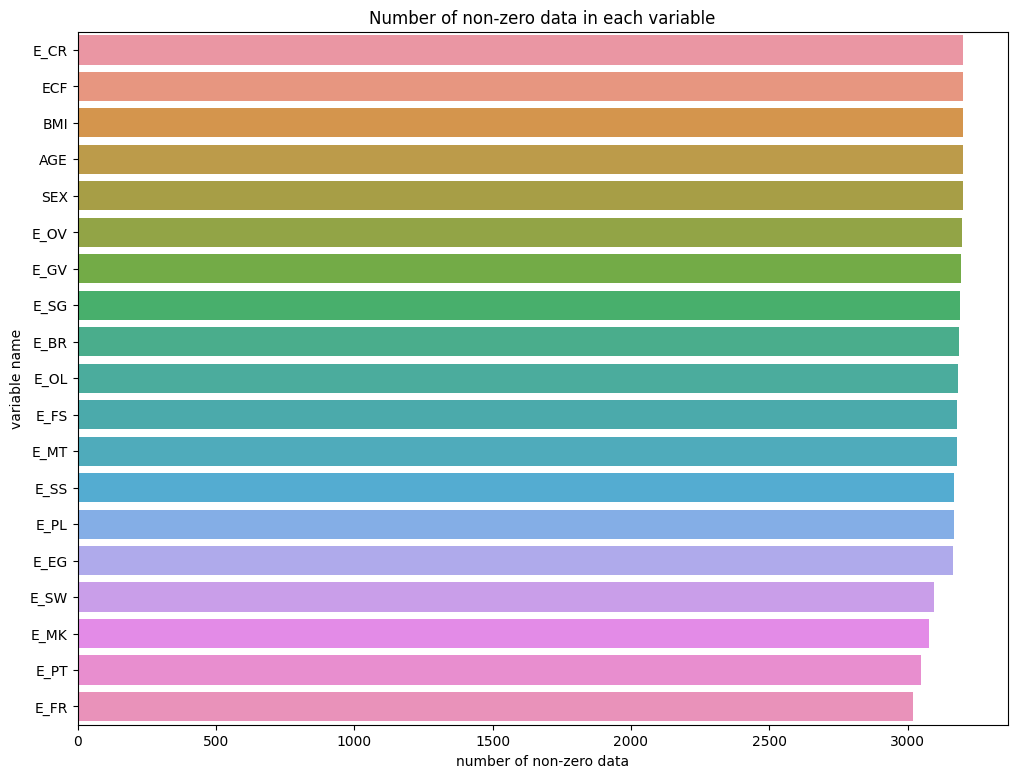

('E_GV', 'E_OV', 0.7040129248500424)
('E_GV', 'E_FR', 0.567757844868274)
('E_OV', 'E_GV', 0.7040129248500424)
('E_FR', 'E_GV', 0.567757844868274)
('E_MT', 'E_OL', 0.5948509316936996)
('E_OL', 'E_MT', 0.5948509316936996)


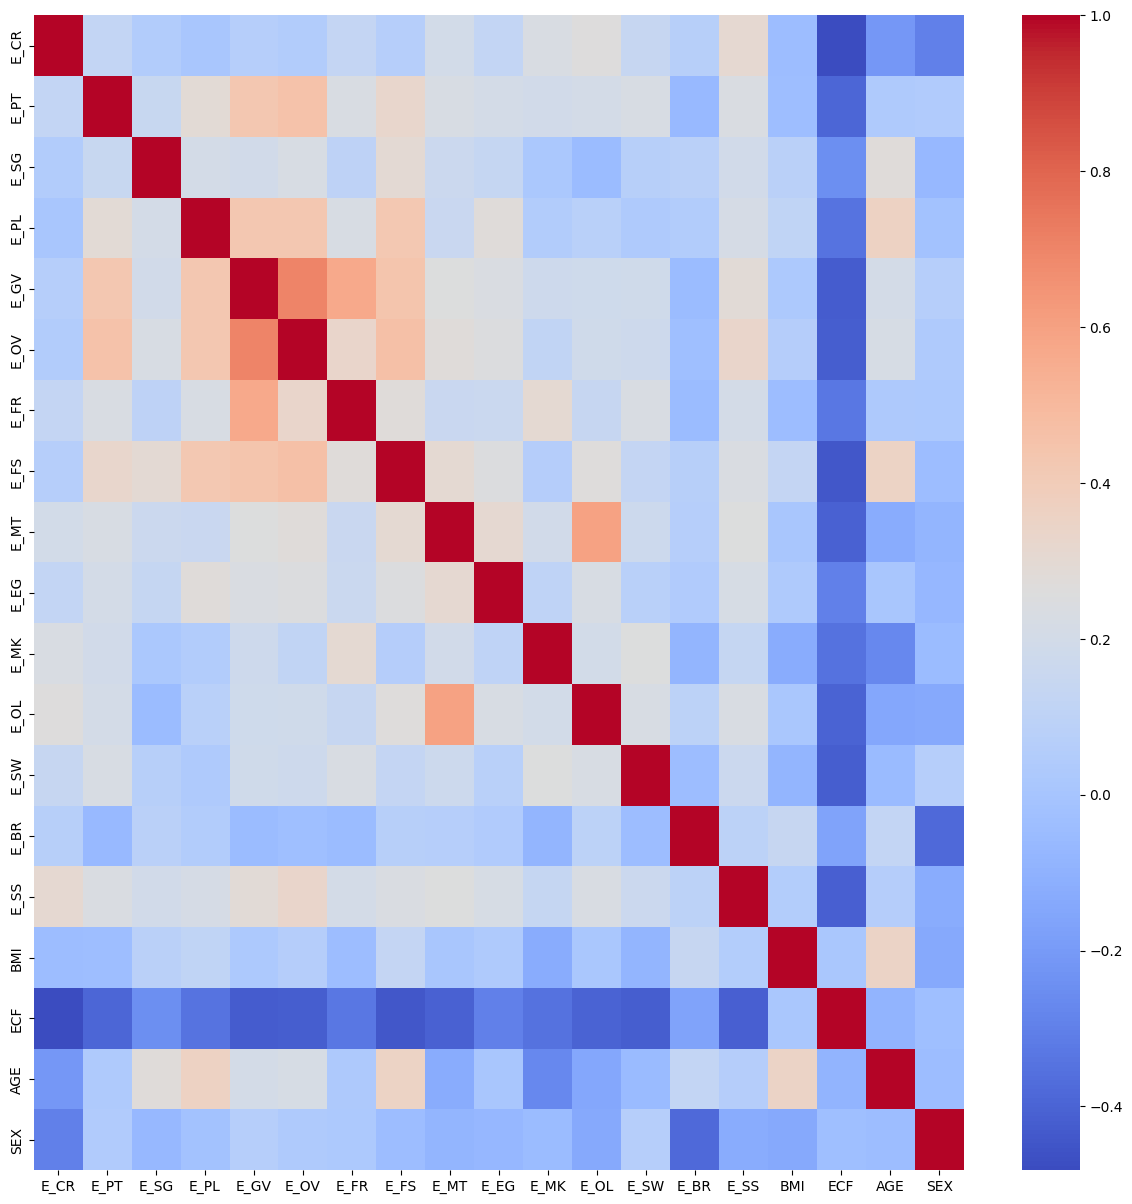

In [ ]:
# 変数の相関を確認
checksVariables(preprocessed_df)

In [ ]:
# 使用する変数を選択
columns_for_lingam =  ['E_CR', 'E_PT', 'E_SG', 'E_PL', 'E_GV', 'E_FS', 'E_MT', 'BMI', 'ECF','SEX','AGE']
variables_df = preprocessed_df[columns_for_lingam]
len(variables_df)

3201

In [ ]:
def ecf_outliers_process(df):
  # ECF列を掛ける
  df = df.drop('ECF', axis=1).multiply(df['ECF'], axis=0)

  # (AGE,SEXを除く変数)
  columns_to_process = df.columns.to_list()
  columns_to_process.remove('AGE')

  # 箱ヒゲ
  # boxplot(df[columns_to_process])

  # # 各変数の変動係数
  # coeff_of_variation = df[columns_to_process].std() / df[columns_to_process].mean() * 100
  # print(coeff_of_variation)

  # # IQRによる外れ値の除去
  df_cleaned_iqr = remove_outliers_iqr(df,columns_to_process)

  # データフレームから少なくとも1つの変数に0データを含む行を除去
  # df = df[(df != 0).all(axis=1)]

  return df[columns_to_process]

In [ ]:
def ecf_outliers_process_drop_0data(df):
  # ECF列を掛ける
  df = df.drop('ECF', axis=1).multiply(df['ECF'], axis=0)

  # (AGE,SEXを除く変数)
  columns_to_process = df.columns.to_list()
  columns_to_process.remove('AGE')

  # 箱ヒゲ
  # boxplot(df[columns_to_process])

  # # 各変数の変動係数
  # coeff_of_variation = df[columns_to_process].std() / df[columns_to_process].mean() * 100
  # print(coeff_of_variation)

  # # IQRによる外れ値の除去
  df_cleaned_iqr = remove_outliers_iqr(df,columns_to_process)

  # データフレームから少なくとも1つの変数に0データを含む行を除去
  df = df[(df != 0).all(axis=1)]

  return df[columns_to_process]

In [ ]:
# fnutr1_data_list <- 全体データ、全体データ(droped_0data)、男性群、男性群、女性群、女性群
fnutr1_data_list = []
fnutr1_data_list.append(ecf_outliers_process(variables_df.drop(['SEX'], axis=1)))

fnutr1_data_list.append(ecf_outliers_process(variables_df[variables_df['SEX'] == 1].drop('SEX', axis=1)))

fnutr1_data_list.append(ecf_outliers_process(variables_df[variables_df['SEX'] == 2].drop('SEX', axis=1)))


In [ ]:
for x in fnutr1_data_list:
  display(x.describe())
  print(len(x))

,E_CR,E_PT,E_SG,E_PL,E_GV,E_FS,E_MT,BMI
count,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000,3201.000000
mean,818.657372,54.923387,21.155028,83.121792,36.093771,157.552252,156.194165,28.044341
std,307.523837,44.075802,17.370164,59.719999,22.045008,102.869763,82.389996,11.896083
min,57.079620,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.572792
25%,594.046261,22.744816,9.189175,38.320270,20.667460,82.277307,100.735759,20.331719
50%,790.668878,46.212378,17.011580,70.616183,32.027800,134.313696,145.233599,25.729675
75%,1002.424452,73.443581,27.340096,115.623418,46.398211,209.393520,197.004642,32.759387
max,2244.665572,400.940458,162.835294,454.121909,238.800375,976.292530,712.780074,153.079097


3201


,E_CR,E_PT,E_SG,E_PL,E_GV,E_FS,E_MT,BMI
count,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000
mean,972.419005,52.424031,23.094057,86.384428,34.583349,168.772282,168.412054,29.320265
std,322.832548,44.835590,20.321517,65.934972,22.741330,109.884170,88.467537,12.906566
min,130.574579,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.019030
25%,762.244058,20.713624,9.066775,38.376700,19.084360,86.753680,110.494062,20.728546
50%,942.641424,43.457508,17.853059,69.870546,30.398483,144.214466,157.808998,27.039102
75%,1171.588422,69.672754,29.551230,118.392089,44.517145,225.226322,210.979654,34.146553
max,2244.665572,323.851723,162.835294,454.121909,166.437788,976.292530,645.768366,153.079097


1261


,E_CR,E_PT,E_SG,E_PL,E_GV,E_FS,E_MT,BMI
count,1940.000000,1940.000000,1940.000000,1940.000000,1940.000000,1940.000000,1940.000000,1940.000000
mean,718.712310,56.547969,19.894660,81.001078,37.075546,150.259233,148.252538,27.214991
std,250.956476,43.509509,15.018550,55.221587,21.529512,97.379703,77.179414,11.115605
min,57.079620,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.572792
25%,540.982332,24.113393,9.229628,38.320120,21.554632,80.303706,95.544381,20.151226
50%,699.875399,47.217162,16.597480,71.090000,33.365306,128.988401,138.568525,24.857150
75%,871.615181,76.199945,26.144701,114.379846,47.803986,199.114021,189.922102,31.518784
max,1694.779393,400.940458,108.169917,397.326892,238.800375,674.852981,712.780074,146.300577


1940


,E_CR,E_PT,E_SG,E_PL,E_GV,E_FS,E_MT,BMI
count,2994.000000,2994.000000,2994.000000,2994.000000,2994.000000,2994.000000,2994.000000,2994.000000
mean,807.380280,57.501160,20.956376,82.680397,36.689740,158.761959,157.380923,27.232338
std,297.119015,42.776261,16.743600,56.692698,21.723476,100.036511,79.973485,10.588985
min,106.505618,4.012092,0.026293,3.063899,0.611187,5.162440,4.921398,4.572792
25%,590.677706,26.079330,9.340821,39.190991,21.225317,84.420706,103.853510,20.122879
50%,782.959529,48.439190,17.002515,71.232757,32.555842,135.381458,145.706187,25.315405
75%,990.545790,75.504307,27.073208,114.822589,46.883568,209.731055,196.420734,32.064318
max,2244.665572,400.940458,162.835294,440.127234,238.800375,674.852981,712.780074,146.300577


2994


,E_CR,E_PT,E_SG,E_PL,E_GV,E_FS,E_MT,BMI
count,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000
mean,955.755307,56.313548,22.635125,84.964251,35.520757,170.882810,170.718982,27.987995
std,309.072677,42.683110,19.533939,60.740742,22.326197,105.654443,85.313229,10.672140
min,130.574579,4.012092,0.026293,3.592268,0.611187,5.406049,12.519013,7.019030
25%,756.210597,25.099404,9.319763,39.174884,19.919935,89.546169,114.133194,20.283138
50%,932.348261,48.708963,17.671423,70.380584,31.509725,145.728328,158.488843,26.414064
75%,1151.290316,72.625541,28.786882,116.775425,45.559235,227.949985,208.634599,33.375563
max,2244.665572,323.851723,162.835294,440.127234,166.437788,633.273411,645.768366,96.902859


1144


,E_CR,E_PT,E_SG,E_PL,E_GV,E_FS,E_MT,BMI
count,1850.000000,1850.000000,1850.000000,1850.000000,1850.000000,1850.000000,1850.000000,1850.000000
mean,715.628372,58.235553,19.918274,81.268111,37.412614,151.266686,149.132956,26.765055
std,248.604161,42.828809,14.666370,54.006605,21.316287,95.662295,75.335838,10.512970
min,106.505618,5.219865,0.141832,3.063899,0.648719,5.162440,4.921398,4.572792
25%,540.169388,26.944937,9.342711,39.220981,21.945560,81.643417,97.162731,19.984713
50%,695.940550,48.334347,16.691407,71.786439,33.978258,130.737433,139.122744,24.679335
75%,865.437313,78.038146,26.220161,113.778723,47.967413,198.880085,189.784269,31.095095
max,1694.779393,400.940458,107.226119,397.326892,238.800375,674.852981,712.780074,146.300577


1850


### LiNGAMの関数定義

In [ ]:
def model_DirectLiNGAM(df,dagname):
  # 標準化
  scaler = StandardScaler()
  Xy = scaler.fit_transform(df)

  # モデル作成
  model = lingam.DirectLiNGAM(random_state=1)
  model.fit(Xy)

  # 因果順序
  print(f"因果の順番\n{model.causal_order_}\n\n_________")

  # 隣接行列
  print("隣接行列\n")
  display(model.adjacency_matrix_)
  print("\n")

  # 因果グラフ
  dot = make_dot(
      model.adjacency_matrix_,
      labels = df.columns.to_list(),
      lower_limit = 0.01)
  display(dot)
  dot.format = 'png'
  dot.render(dagname)

  # 推定した因果モデルにおける、誤差同士の独立性のp値
  p_values = model.get_error_independence_p_values(Xy)
  display(p_values)

  return model

In [ ]:
def model_MultiDirectLiNGAM(df_list):
  # 標準化
  scaler = StandardScaler()
  Xy_list = []
  for df in df_list:
    Xy_list.append(scaler.fit_transform(df))

  # モデル作成
  model = lingam.MultiGroupDirectLiNGAM(random_state=1)
  model.fit(Xy_list)

  for index in range(len(Xy_list)):
    # 因果順序
    print(f"因果順序\n{model.causal_order_}\n\n")

    # 隣接行列
    print(f"隣接行列")
    display(model.adjacency_matrices_[index])
    print("\n")

    # 因果グラフの表示と保存
    dot = make_dot(model.adjacency_matrices_[index],
            labels = df_list[index].columns.to_list(),
            lower_limit = 0.01)
    display(dot)
    dot.format = 'png'
    dagname = f"fnutr1_Direct{index}"
    dot.render(dagname)

    # 因果モデルにおける誤差同士の独立性のp値
    p_values = model.get_error_independence_p_values(df_list)
    display(p_values[index])

  # return model

In [ ]:
def model_bootstrap(df, n_sampling):
    scaler = StandardScaler()
    Xy = scaler.fit_transform(df)

    model = lingam.DirectLiNGAM(random_state=1)
    result = model.bootstrap(Xy, n_sampling=n_sampling)
    # sklearn.utils.resampleで重複ありのリサンプリングをしている。リサンプル後のサンプル数は元データと同じ。

    # bootstrappingの各サンプルにおける、因果方向の有無のカウント結果を取得する
    cdc = result.get_causal_direction_counts(n_directions=10, min_causal_effect=0.01, split_by_causal_effect_sign=True)
    print_causal_directions(cdc, n_sampling, labels=df.columns.to_list())

    # カウント結果を確率として、隣接行列の形式で表示
    prob = result.get_probabilities(min_causal_effect=0.01)
    print(prob)

    # bootstrappingの各サンプルにおける、DAG(Directed Acyclic Graphs)のカウント結果を取得する
    dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)
    print_dagc(dagc, n_sampling, labels=df.columns.to_list())

    # Total Causal Effects
    causal_effects = result.get_total_causal_effects(min_causal_effect=0.01)

    # Assign to pandas.DataFrame for pretty display
    df_ = pd.DataFrame(causal_effects)
    labels = df.columns.to_list()
    # 'from' 列と 'to' 列のラベルを適用する
    df_['from'] = df_['from'].apply(lambda x: labels[x])
    df_['to'] = df_['to'].apply(lambda x: labels[x])
    return df_

In [ ]:
def model_MultiBootstrap(df_list, n_sampling):
    # 標準化
    scaler = StandardScaler()
    Xy_list = []
    for df in df_list:
      Xy_list.append(scaler.fit_transform(df))

    # モデル作成
    model = lingam.MultiGroupDirectLiNGAM(random_state=1)
    result = model.bootstrap(Xy_list, n_sampling=n_sampling)
    # sklearn.utils.resampleで重複ありのリサンプリングをしている。リサンプル後のサンプル数は元データと同じ。

    # 各グループの結果を表示
    for idx in range(len(Xy_list)):
      print(f"fnutr1_bootstrap_{idx}=============================================")
      # bootstrappingの各サンプルにおける、因果方向の有無のカウント結果を取得する
      cdc = result[idx].get_causal_direction_counts(n_directions=10, min_causal_effect=0.01, split_by_causal_effect_sign=True)
      print("因果方法top10")
      print_causal_directions(cdc, n_sampling, labels=df.columns.to_list())
      print()

      # カウント結果を確率として、隣接行列の形式で表示
      prob = result[idx].get_probabilities(min_causal_effect=0.01)
      print("カウント確率")
      display(prob)
      print()

      # bootstrappingの各サンプルにおける、DAG(Directed Acyclic Graphs)のカウント結果を取得する
      dagc = result[idx].get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)
      print("DAGのカウント結果")
      print_dagc(dagc, n_sampling, labels=df.columns.to_list())
      print()

      # Total Causal Effects
      causal_effects = result[idx].get_total_causal_effects(min_causal_effect=0.01)

      # Assign to pandas.DataFrame for pretty display
      df_ = pd.DataFrame(causal_effects)
      labels = df_list[idx].columns.to_list()
      # 'from' 列と 'to' 列のラベルを適用する
      df_['from'] = df_['from'].apply(lambda x: labels[x])
      df_['to'] = df_['to'].apply(lambda x: labels[x])
      display(df_)


因果順序
[5, 4, 6, 3, 2, 7, 1, 0]


隣接行列


array([[ 0.        , -0.08913154,  0.        , -0.15352486, -0.17923891,
        -0.26639865, -0.09368348,  0.11645487],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.23952701,
         0.        ,  0.        , -0.11515832],
       [ 0.        ,  0.        ,  0.        ,  0.07444369,  0.        ,
         0.10946072,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.19367066,
         0.20420529, -0.0759316 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.21833109,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.12948811,  0.11171874,  0.        ,
        -0.11556218,  0.06478951,  0.        ]])

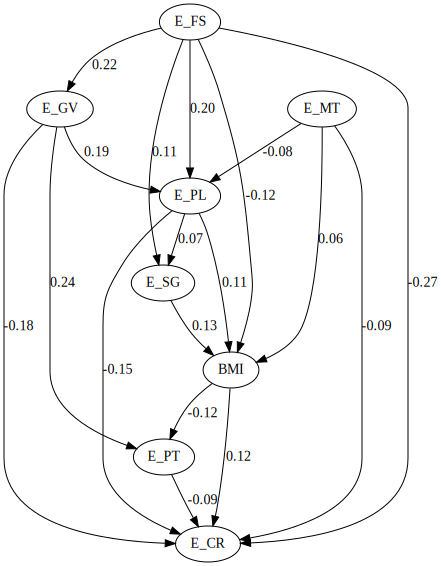

array([[0.00000000e+000, 1.28045955e-024, 3.34879490e-026,
        4.57314136e-022, 1.33275961e-009, 2.68561652e-054,
        4.37868487e-006, 7.21165546e-002],
       [1.28045955e-024, 0.00000000e+000, 1.67087085e-006,
        1.01400933e-011, 5.94502679e-004, 2.95242058e-014,
        1.42947863e-014, 5.49716760e-005],
       [3.34879490e-026, 1.67087085e-006, 0.00000000e+000,
        1.00969485e-037, 6.64572285e-147, 0.00000000e+000,
        6.14068071e-002, 2.93201709e-103],
       [4.57314136e-022, 1.01400933e-011, 1.00969485e-037,
        0.00000000e+000, 2.37647090e-027, 1.16155268e-013,
        5.53354919e-007, 5.36068770e-174],
       [1.33275961e-009, 5.94502679e-004, 6.64572285e-147,
        2.37647090e-027, 0.00000000e+000, 0.00000000e+000,
        8.76351439e-003, 6.22081771e-209],
       [2.68561652e-054, 2.95242058e-014, 0.00000000e+000,
        1.16155268e-013, 0.00000000e+000, 0.00000000e+000,
        6.82554712e-006, 0.00000000e+000],
       [4.37868487e-006, 1.4294786

因果順序
[5, 4, 6, 3, 2, 7, 1, 0]


隣接行列


array([[ 0.        , -0.08213523,  0.        , -0.16191203, -0.16419589,
        -0.32612298, -0.14085317,  0.08379939],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.25270177,
         0.        ,  0.        , -0.17802704],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.11114139,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.16860744,
         0.22178364, -0.08270271,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.239922  ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.08310282,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.14815844,  0.16906232,  0.        ,
        -0.10227704,  0.06881469,  0.        ]])

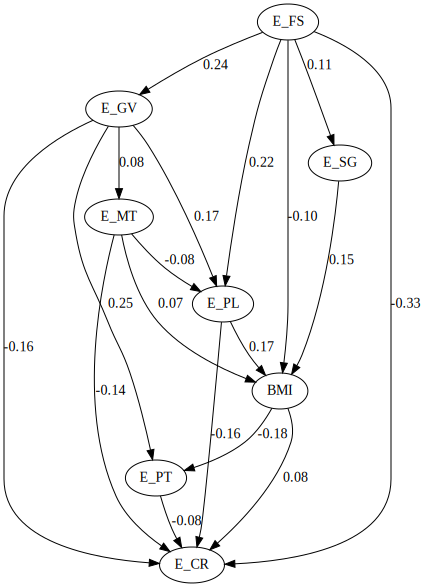

array([[0.00000000e+000, 1.22101438e-008, 4.76972226e-004,
        5.10236810e-005, 1.23551778e-009, 1.09540096e-025,
        1.35087744e-005, 1.67361351e-001],
       [1.22101438e-008, 0.00000000e+000, 1.29101177e-002,
        9.15590424e-006, 6.72206188e-003, 3.65851356e-003,
        6.05478533e-008, 1.82144356e-007],
       [4.76972226e-004, 1.29101177e-002, 0.00000000e+000,
        6.57562254e-010, 6.05024167e-065, 8.54897968e-101,
        1.19352420e-001, 1.74975975e-042],
       [5.10236810e-005, 9.15590424e-006, 6.57562254e-010,
        0.00000000e+000, 2.25915461e-013, 4.27022796e-010,
        1.05690221e-005, 1.45741920e-135],
       [1.23551778e-009, 6.72206188e-003, 6.05024167e-065,
        2.25915461e-013, 0.00000000e+000, 3.34247844e-203,
        3.27810055e-001, 3.53275668e-070],
       [1.09540096e-025, 3.65851356e-003, 8.54897968e-101,
        4.27022796e-010, 3.34247844e-203, 0.00000000e+000,
        3.79287535e-002, 3.02975614e-071],
       [1.35087744e-005, 6.0547853

因果順序
[5, 4, 6, 3, 2, 7, 1, 0]


隣接行列


array([[ 0.        , -0.08296795, -0.0571716 , -0.20796843, -0.15157618,
        -0.34486651, -0.1688936 ,  0.10016576],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.21279228,
         0.08063756,  0.        , -0.05444525],
       [ 0.        ,  0.        ,  0.        ,  0.09687813,  0.        ,
         0.10921066,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.22136792,
         0.1795002 , -0.07930794,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.21259312,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.10923289,  0.        ,  0.        ,
        -0.12621977,  0.        ,  0.        ]])

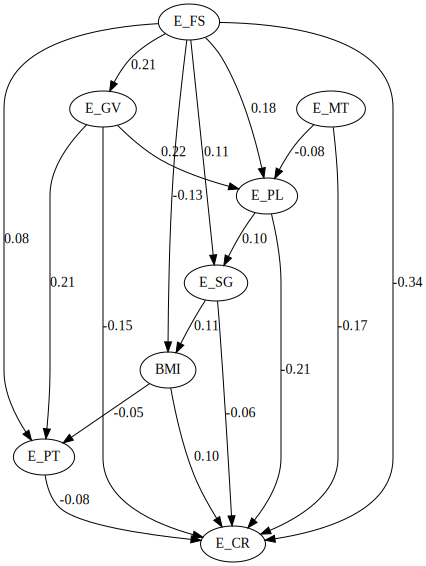

array([[0.00000000e+000, 3.19274941e-010, 3.11199326e-037,
        7.15036132e-027, 2.68681472e-008, 2.27099263e-057,
        1.28240561e-003, 1.24772302e-007],
       [3.19274941e-010, 0.00000000e+000, 6.84461159e-008,
        3.15078157e-006, 2.66965106e-010, 5.65163789e-005,
        1.85836870e-004, 5.56817723e-010],
       [3.11199326e-037, 6.84461159e-008, 0.00000000e+000,
        4.45681781e-038, 4.66942308e-073, 1.81713232e-193,
        2.83493712e-002, 1.17163794e-119],
       [7.15036132e-027, 3.15078157e-006, 4.45681781e-038,
        0.00000000e+000, 6.82524340e-009, 1.64442500e-003,
        2.60712315e-003, 1.63872718e-008],
       [2.68681472e-008, 2.66965106e-010, 4.66942308e-073,
        6.82524340e-009, 0.00000000e+000, 2.20796007e-186,
        2.36542867e-002, 3.47177467e-106],
       [2.27099263e-057, 5.65163789e-005, 1.81713232e-193,
        1.64442500e-003, 2.20796007e-186, 0.00000000e+000,
        1.71553749e-004, 0.00000000e+000],
       [1.28240561e-003, 1.8583687

In [ ]:
# # マルチリンガム
model = model_MultiDirectLiNGAM(fnutr1_data_list)

In [ ]:
# ブートストラップ法：引数（データフレームリスト, サンプル回数）
pretty_causal_effects = model_MultiBootstrap(fnutr1_data_list, 1000)
display(pretty_causal_effects)

fnutr1_bootstrap_0=============================================
因果方法top10
BMI <--- E_SG (b>0) (100.0%)
E_CR <--- E_FS (b<0) (100.0%)
E_SG <--- E_FS (b>0) (100.0%)
E_PT <--- BMI (b<0) (99.8%)
E_PT <--- E_GV (b>0) (99.2%)
BMI <--- E_PL (b>0) (99.1%)
E_PL <--- E_FS (b>0) (98.4%)
E_PL <--- E_GV (b>0) (98.3%)
E_CR <--- E_MT (b<0) (97.3%)
BMI <--- E_FS (b<0) (96.2%)

カウント確率


array([[0.   , 0.692, 0.071, 0.776, 0.925, 1.   , 0.973, 0.7  ],
       [0.308, 0.   , 0.085, 0.355, 0.992, 0.315, 0.112, 0.998],
       [0.001, 0.   , 0.   , 0.354, 0.012, 1.   , 0.078, 0.   ],
       [0.224, 0.006, 0.583, 0.   , 0.983, 0.984, 0.873, 0.008],
       [0.075, 0.008, 0.009, 0.017, 0.   , 0.922, 0.027, 0.004],
       [0.   , 0.   , 0.   , 0.016, 0.078, 0.   , 0.019, 0.   ],
       [0.022, 0.   , 0.011, 0.093, 0.02 , 0.045, 0.   , 0.018],
       [0.3  , 0.   , 1.   , 0.991, 0.252, 0.962, 0.854, 0.   ]])


DAGのカウント結果
DAG[0]: 4.7%
	E_CR <--- E_PT (b<0)
	E_CR <--- E_PL (b<0)
	E_CR <--- E_GV (b<0)
	E_CR <--- E_FS (b<0)
	E_CR <--- E_MT (b<0)
	E_CR <--- BMI (b>0)
	E_PT <--- E_GV (b>0)
	E_PT <--- BMI (b<0)
	E_SG <--- E_FS (b>0)
	E_PL <--- E_SG (b>0)
	E_PL <--- E_GV (b>0)
	E_PL <--- E_FS (b>0)
	E_PL <--- E_MT (b<0)
	E_GV <--- E_FS (b>0)
	BMI <--- E_SG (b>0)
	BMI <--- E_PL (b>0)
	BMI <--- E_FS (b<0)
	BMI <--- E_MT (b>0)
DAG[1]: 3.6%
	E_CR <--- E_GV (b<0)
	E_CR <--- E_FS (b<0)
	E_CR <--- E_MT (b<0)
	E_PT <--- E_CR (b<0)
	E_PT <--- E_GV (b>0)
	E_PT <--- BMI (b<0)
	E_SG <--- E_FS (b>0)
	E_PL <--- E_CR (b<0)
	E_PL <--- E_SG (b>0)
	E_PL <--- E_GV (b>0)
	E_PL <--- E_FS (b>0)
	E_PL <--- E_MT (b<0)
	E_GV <--- E_FS (b>0)
	BMI <--- E_CR (b>0)
	BMI <--- E_SG (b>0)
	BMI <--- E_PL (b>0)
	BMI <--- E_FS (b<0)
	BMI <--- E_MT (b>0)
DAG[2]: 2.8%
	E_CR <--- E_PT (b<0)
	E_CR <--- E_PL (b<0)
	E_CR <--- E_GV (b<0)
	E_CR <--- E_FS (b<0)
	E_CR <--- E_MT (b<0)
	E_CR <--- BMI (b>0)
	E_PT <--- E_PL (b>0)
	E_PT <--- E_GV 

,from,to,effect,probability
0,E_FS,E_CR,-0.359494,1.000
1,E_SG,BMI,0.134032,1.000
2,E_FS,E_SG,0.127759,1.000
3,BMI,E_PT,-0.114135,0.997
4,E_GV,E_PT,0.230811,0.992
5,E_PL,BMI,0.121857,0.991
6,E_FS,E_PL,0.243448,0.984
7,E_GV,E_PL,0.193433,0.983
8,E_FS,E_PT,0.104211,0.966
9,E_MT,E_CR,-0.085915,0.961


fnutr1_bootstrap_1=============================================
因果方法top10
E_CR <--- E_FS (b<0) (100.0%)
E_PT <--- BMI (b<0) (99.9%)
E_PT <--- E_GV (b>0) (99.2%)
BMI <--- E_PL (b>0) (98.6%)
E_PL <--- E_FS (b>0) (98.4%)
BMI <--- E_SG (b>0) (98.4%)
E_PL <--- E_GV (b>0) (97.9%)
E_CR <--- E_MT (b<0) (97.5%)
E_CR <--- E_GV (b<0) (92.5%)
E_GV <--- E_FS (b>0) (92.2%)

カウント確率


array([[0.   , 0.625, 0.222, 0.776, 0.925, 1.   , 0.975, 0.609],
       [0.26 , 0.   , 0.074, 0.497, 0.992, 0.048, 0.316, 0.999],
       [0.006, 0.   , 0.   , 0.137, 0.021, 0.869, 0.014, 0.   ],
       [0.224, 0.006, 0.142, 0.   , 0.979, 0.984, 0.654, 0.007],
       [0.075, 0.008, 0.02 , 0.016, 0.   , 0.922, 0.446, 0.004],
       [0.   , 0.   , 0.   , 0.016, 0.077, 0.   , 0.036, 0.   ],
       [0.022, 0.001, 0.01 , 0.088, 0.123, 0.061, 0.   , 0.017],
       [0.297, 0.   , 0.984, 0.986, 0.114, 0.71 , 0.614, 0.   ]])


DAGのカウント結果
DAG[0]: 0.8%
	E_CR <--- E_PT (b<0)
	E_CR <--- E_PL (b<0)
	E_CR <--- E_GV (b<0)
	E_CR <--- E_FS (b<0)
	E_CR <--- E_MT (b<0)
	E_CR <--- BMI (b>0)
	E_PT <--- E_GV (b>0)
	E_PT <--- BMI (b<0)
	E_SG <--- E_FS (b>0)
	E_PL <--- E_GV (b>0)
	E_PL <--- E_FS (b>0)
	E_PL <--- E_MT (b<0)
	E_GV <--- E_FS (b>0)
	E_GV <--- E_MT (b>0)
	BMI <--- E_SG (b>0)
	BMI <--- E_PL (b>0)
	BMI <--- E_FS (b<0)
	BMI <--- E_MT (b>0)
DAG[1]: 0.8%
	E_CR <--- E_PT (b<0)
	E_CR <--- E_PL (b<0)
	E_CR <--- E_GV (b<0)
	E_CR <--- E_FS (b<0)
	E_CR <--- E_MT (b<0)
	E_CR <--- BMI (b>0)
	E_PT <--- E_GV (b>0)
	E_PT <--- BMI (b<0)
	E_SG <--- E_FS (b>0)
	E_PL <--- E_GV (b>0)
	E_PL <--- E_FS (b>0)
	E_PL <--- E_MT (b<0)
	E_GV <--- E_FS (b>0)
	E_GV <--- E_MT (b>0)
	BMI <--- E_SG (b>0)
	BMI <--- E_PL (b>0)
	BMI <--- E_FS (b<0)
DAG[2]: 0.7%
	E_CR <--- E_PT (b<0)
	E_CR <--- E_SG (b<0)
	E_CR <--- E_PL (b<0)
	E_CR <--- E_GV (b<0)
	E_CR <--- E_FS (b<0)
	E_CR <--- E_MT (b<0)
	E_CR <--- BMI (b>0)
	E_PT <--- E_GV (b>0)
	E_PT <--- BMI 

,from,to,effect,probability
0,E_FS,E_CR,-0.421015,1.000
1,BMI,E_PT,-0.190950,1.000
2,E_GV,E_PT,0.251395,0.992
3,E_FS,E_PL,0.255186,0.984
4,E_PL,BMI,0.174425,0.980
5,E_GV,E_PL,0.167842,0.979
6,E_SG,BMI,0.149439,0.974
7,E_MT,E_CR,-0.154430,0.973
8,E_GV,E_CR,-0.217620,0.925
9,E_FS,E_GV,0.241093,0.922


fnutr1_bootstrap_2=============================================
因果方法top10
E_CR <--- E_FS (b<0) (100.0%)
E_SG <--- E_FS (b>0) (99.4%)
E_PT <--- E_GV (b>0) (99.2%)
E_PL <--- E_GV (b>0) (98.3%)
E_CR <--- E_MT (b<0) (97.8%)
BMI <--- E_SG (b>0) (97.0%)
BMI <--- E_FS (b<0) (94.9%)
E_PL <--- E_FS (b>0) (94.2%)
E_CR <--- E_GV (b<0) (92.5%)
E_GV <--- E_FS (b>0) (91.2%)

カウント確率


array([[0.   , 0.679, 0.711, 0.776, 0.925, 1.   , 0.978, 0.696],
       [0.303, 0.   , 0.039, 0.11 , 0.992, 0.625, 0.026, 0.459],
       [0.036, 0.   , 0.   , 0.354, 0.053, 0.994, 0.201, 0.   ],
       [0.224, 0.   , 0.58 , 0.   , 0.983, 0.942, 0.819, 0.006],
       [0.075, 0.008, 0.014, 0.017, 0.   , 0.912, 0.065, 0.004],
       [0.   , 0.   , 0.   , 0.016, 0.078, 0.   , 0.011, 0.   ],
       [0.022, 0.   , 0.02 , 0.091, 0.012, 0.025, 0.   , 0.014],
       [0.3  , 0.   , 0.97 , 0.598, 0.148, 0.949, 0.445, 0.   ]])


DAGのカウント結果
DAG[0]: 1.9%
	E_CR <--- E_PT (b<0)
	E_CR <--- E_SG (b<0)
	E_CR <--- E_PL (b<0)
	E_CR <--- E_GV (b<0)
	E_CR <--- E_FS (b<0)
	E_CR <--- E_MT (b<0)
	E_CR <--- BMI (b>0)
	E_PT <--- E_GV (b>0)
	E_PT <--- E_FS (b>0)
	E_SG <--- E_FS (b>0)
	E_PL <--- E_SG (b>0)
	E_PL <--- E_GV (b>0)
	E_PL <--- E_FS (b>0)
	E_PL <--- E_MT (b<0)
	E_GV <--- E_FS (b>0)
	BMI <--- E_SG (b>0)
	BMI <--- E_FS (b<0)
DAG[1]: 1.5%
	E_CR <--- E_PT (b<0)
	E_CR <--- E_SG (b<0)
	E_CR <--- E_PL (b<0)
	E_CR <--- E_GV (b<0)
	E_CR <--- E_FS (b<0)
	E_CR <--- E_MT (b<0)
	E_CR <--- BMI (b>0)
	E_PT <--- E_GV (b>0)
	E_PT <--- E_FS (b>0)
	E_SG <--- E_FS (b>0)
	E_PL <--- E_SG (b>0)
	E_PL <--- E_GV (b>0)
	E_PL <--- E_FS (b>0)
	E_PL <--- E_MT (b<0)
	E_GV <--- E_FS (b>0)
	BMI <--- E_SG (b>0)
	BMI <--- E_PL (b>0)
	BMI <--- E_FS (b<0)
DAG[2]: 1.2%
	E_CR <--- E_PT (b<0)
	E_CR <--- E_SG (b<0)
	E_CR <--- E_PL (b<0)
	E_CR <--- E_GV (b<0)
	E_CR <--- E_FS (b<0)
	E_CR <--- E_MT (b<0)
	E_CR <--- BMI (b>0)
	E_PT <--- E_GV (b>0)
	E_PT <--- 

,from,to,effect,probability
0,E_FS,E_CR,-0.450202,1.000
1,E_FS,E_SG,0.130131,0.999
2,E_GV,E_PT,0.214587,0.992
3,E_FS,E_PT,0.128372,0.992
4,E_FS,E_PL,0.226434,0.984
5,E_GV,E_PL,0.224832,0.983
6,E_FS,BMI,-0.113392,0.980
7,E_MT,E_CR,-0.142138,0.977
8,E_SG,BMI,0.108651,0.976
9,E_GV,E_CR,-0.218345,0.925


None

##--サンプリング回数1000
##全体4.7%、男性0.8%、女性1.9%。<br>食べ物単体よりも、ある程度同じような食べ物のグループで見てやると影響を認識しやすい（or 影響が大きくなりやすい）のだろうか。魚、野菜、ついで肉あたりは他の変数からの影響をあまり受けず、穀類や芋類は他の食べ物からの影響を受けやすいよう。摂取量とエネルギーでの違いはなんだろうか。同じような変数でfoodをやり直して検討すべきか。